In [1]:
import numpy as np
import pandas as pd
from tensorly.decomposition import  partial_tucker,parafac2
import tensorly as tl
from tensorly.parafac2_tensor import parafac2_to_slice, apply_parafac2_projections
from tfac.Data_Mod import form_tensor
from tfac.tensor import partial_tucker_decomp, find_R2X_partialtucker, flip_factors
from pseudoinvnorm import get_Flattened_Matrices, get_reconstruct
from pybiomart import Server
import gseapy as gp
import copy
tl.set_backend("numpy")

In [2]:
#decompse the tensor
component = 5
tensor, treatment_list, times = form_tensor()
pre_flip_result = partial_tucker_decomp(tensor, [2], component)
result = flip_factors(pre_flip_result)
#load the gene expression data
geneexpression = pd.read_csv("tfac/data/ohsu/MDD_RNAseq_Level4.csv")
ids = geneexpression["ensembl_gene_id"]

In [3]:
P, X = get_Flattened_Matrices(result, geneexpression, treatment_list, times)
Ppinv, W = get_reconstruct(P,X)
df = pd.DataFrame(W.T)

In [4]:
def find_unique(df):
    "For given component prerank results, determines for each geneset how many components have larger positive/negative magnitude NES"
    largepos = []
    largeneg = []
    for geneset in df.index:
        counti = 0
        countn = 0
        if geneset in alls.index:
            for comp in alls.loc[geneset]:
                if comp > 1 * df.loc[geneset][1] and df.loc[geneset][1] > 0:
                    counti += 1
                if comp < -1 * df.loc[geneset][1] and df.loc[geneset][1] > 0:
                    countn += 1
                if comp < 1 * df.loc[geneset][1] and df.loc[geneset][1] < 0:
                    countn += 1
                if comp > -1 * df.loc[geneset][1] and df.loc[geneset][1] < 0:
                    counti += 1
        largepos.append(counti)
        largeneg.append(countn)
    df["largepos"] = largepos
    df["largeneg"] = largeneg
    
def ensembl_convert(df, geneids, decimals):
    convtable = pd.DataFrame()
    server = Server(host='http://www.ensembl.org')
    dataset = (server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl'])
    convtable = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
    ourids = copy.deepcopy(geneids)
    if(decimals):
        for a in range(len(ourids)):
            ourids[a] = ourids[a][:ourids[a].index(".") ]
            
    
    newnames = []
    newtens = pd.DataFrame(df)
    newtens["ensembl ids"] = ourids
    droppedids = newtens[~newtens["ensembl ids"].isin(convtable["Gene stable ID"])]
    newtens = newtens[newtens["ensembl ids"].isin(convtable["Gene stable ID"])]
    for ensid in newtens["ensembl ids"]:
        table = convtable[convtable["Gene stable ID"] == ensid]
        table.reset_index(inplace = True)
        newnames.append(table.at[0, "Gene name"])

    newtens["Gene ID"] = newnames
    
    return newtens

def gsea(newtens, component, lib):
    prtens = pd.concat((newtens["Gene ID"], newtens[newtens.columns[component]]), axis = 1)
    pre_res = gp.prerank(rnk=prtens, gene_sets=lib, processes=4, max_size=500, permutation_num=100, weighted_score_type=1.5, outdir=None, format='png', seed=6)
    return pre_res.res2d.sort_index()

In [5]:
df = ensembl_convert(df, ids, False)


In [6]:
yert = gsea(df,3, 'GO_Biological_Process_2018')
yert.head()

2020-11-30 08:17:38,760 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


es       nes  \
Term                                                                     
'de novo' posttranslational protein folding (GO... -0.829088 -1.188483   
2-oxoglutarate metabolic process (GO:0006103)      -0.809355 -1.079869   
3'-UTR-mediated mRNA stabilization (GO:0070935)    -0.813556 -1.129519   
3'-phosphoadenosine 5'-phosphosulfate metabolic... -0.817514 -1.079276   
7-methylguanosine RNA capping (GO:0009452)         -0.843730 -1.190337   

                                                        pval       fdr  \
Term                                                                     
'de novo' posttranslational protein folding (GO...  0.150538  0.756230   
2-oxoglutarate metabolic process (GO:0006103)       0.437500  0.808824   
3'-UTR-mediated mRNA stabilization (GO:0070935)     0.322581  0.670606   
3'-phosphoadenosine 5'-phosphosulfate metabolic...  0.275510  0.811401   
7-methylguanosine RNA capping (GO:0009452)          0.115789  0.758890   

                                                    geneset_size  \
Term                                                               
'de novo' posttranslational protein folding (GO...            31   
2-oxoglutarate metabolic process (GO:0006103)                 17   
3'-UTR-mediated mRNA stabilization (GO:0070935)               17   
3'-phosphoadenosine 5'-phosphosulfate metabolic...            26   
7-methylguanosine RNA capping (GO:0009452)                    33   

                                                    matched_size  \
Term                                                               
'de novo' posttranslational protein folding (GO...            30   
2-oxoglutarate metabolic process (GO:0006103)                 17   
3'-UTR-mediated mRNA stabilization (GO:0070935)               17   
3'-phosphoadenosine 5'-phosphosulfate metabolic...            25   
7-methylguanosine RNA capping (GO:0009452)                    31   

                                                                                                genes  \
Term                                                                                                    
'de novo' posttranslational protein folding (GO...  HSPA7;HSPA6;HSPA13;HSPA1L;ENTPD5;DNAJB14;HSPA1...   
2-oxoglutarate metabolic process (GO:0006103)       STAT5A;GPT2;TAT;ADHFE1;AADAT;L2HGDH;GHR;STAT5B...   
3'-UTR-mediated mRNA stabilization (GO:0070935)     BOLL;DAZ4;DAZ2;DAZ1;DAZ3;DAZL;MYD88;TIRAP;ZFP3...   
3'-phosphoadenosine 5'-phosphosulfate metabolic...  SULT1C4;SULT4A1;SULT6B1;SULT2A1;SULT1C2;ENPP1;...   
7-methylguanosine RNA capping (GO:0009452)          CMTR1;GTF2H2;POLR2A;GTF2H5;CMTR2;RNMT;GTF2H1;G...   

                                                                                          ledge_genes  
Term                                                                                                   
'de novo' posttranslational protein folding (GO...  UGGT2;ERO1A;DNAJC7;HYOU1;CHCHD4;DNAJB12;HSPH1;...  
2-oxoglutarate metabolic process (GO:0006103)       STAT5B;IDH2;OGDH;PHYH;GOT1;D2HGDH;MRPS36;IDH1;...  
3'-UTR-mediated mRNA stabilization (GO:0070935)     TIRAP;ZFP36;ELAVL1;ANGEL2;MAPK14;HNRNPA0;MAPKA...  
3'-phosphoadenosine 5'-phosphosulfate metabolic...  PODXL2;TPST2;SULT1A1;IMPAD1;SULT1A3;PAPSS1;TPS...  
7-methylguanosine RNA capping (GO:0009452)          RNMT;GTF2H1;GTF2H3;RNGTT;MNAT1;POLR2D;CCNH;GTF...

In [16]:
lib_list = ['GO_Biological_Process_2018','GO_Cellular_Component_2018','GO_Molecular_Function_2018','KEGG_2019_Human','BioPlanet_2019', 'Genes_Associated_with_NIH_Grants']
ret = []
for lib in lib_list:
    add = []
    for i in range(5):
        to_add = gsea(df,i,lib)
        add.append(to_add)
    ret.append(add)

2020-11-30 12:11:24,013 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:16:57,918 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:22:32,110 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:28:05,658 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:33:32,974 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:39:07,021 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:39:46,377 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:40:26,419 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2020-11-30 12:41:06,055 Input gene rankings contains duplicated IDs, Onl

In [14]:
ret_filter = []

for lib in ret:
    add = []
    for a in lib:
        add.append(a[a["fdr"] < 0.05])
    ret_filter.append(add)
    

In [15]:
for a in ret_filter:
    print(len(a))

12
0
4
0
5
31


Text(0.5, 1.0, 'Component 5')

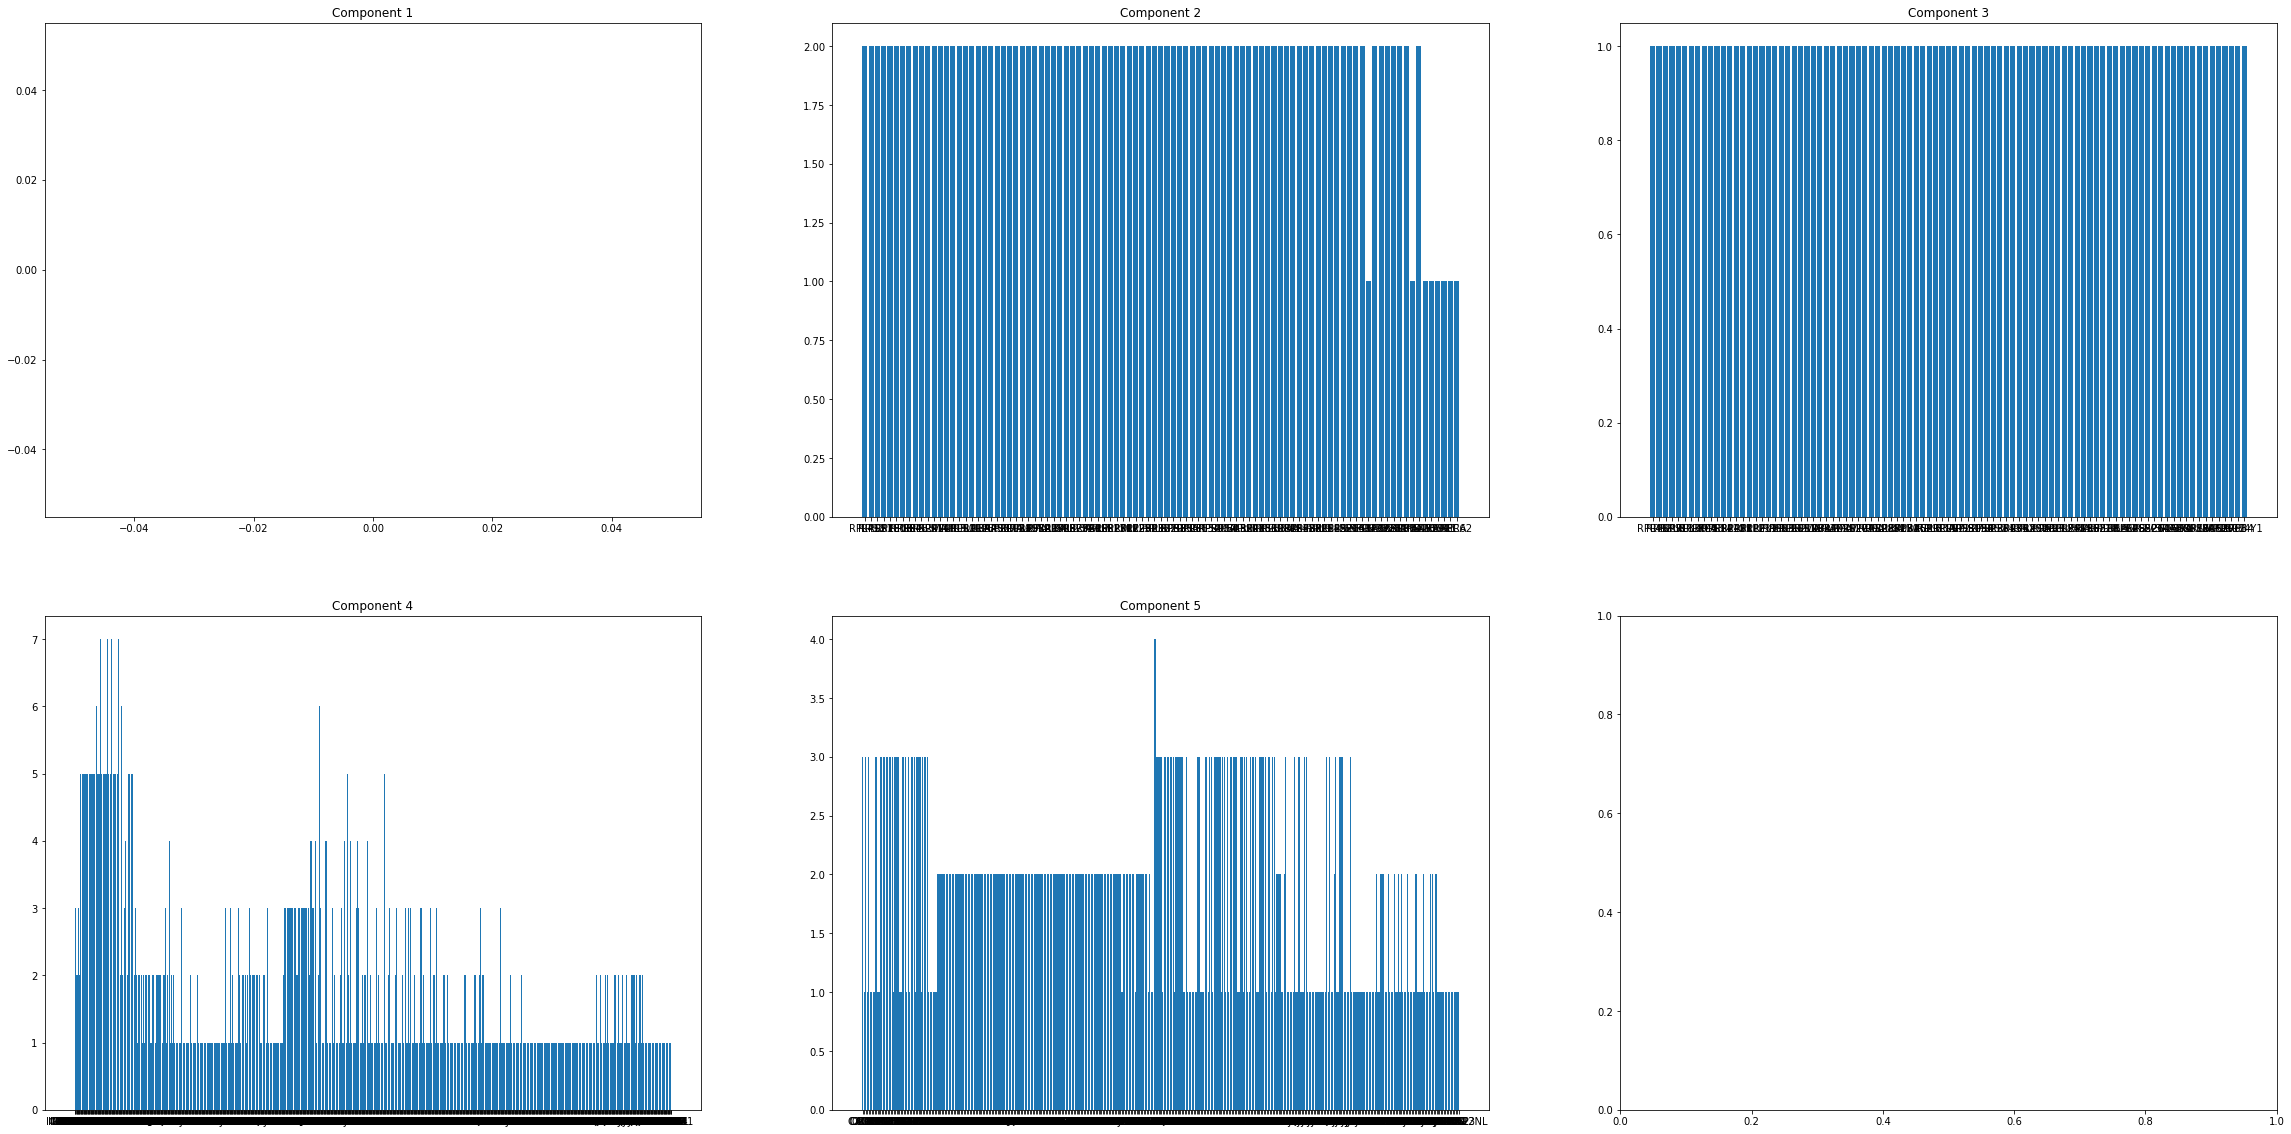

In [2]:
filtered=[]
set=[]
for i in range(30):
    set.append(pd.read_pickle('gsea_dfs/'+str(i)+'.pkl'))
    if ((i+1)%5==0):
        filtered.append(set)
        set = []
filtered_dicts=[]
for j in filtered:
    set = []
    for i in j:
        my_dict = {}
        for r in range(len(i)):
            genes = i['genes'][r].split(';')
            for gene in genes:
                if gene in my_dict:
                    my_dict[gene] +=1
                else:
                    my_dict[gene] = 1
        set.append(my_dict)
    filtered_dicts.append(set)

import matplotlib.pyplot as plt
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 0
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

Text(0.5, 1.0, 'Component 5')

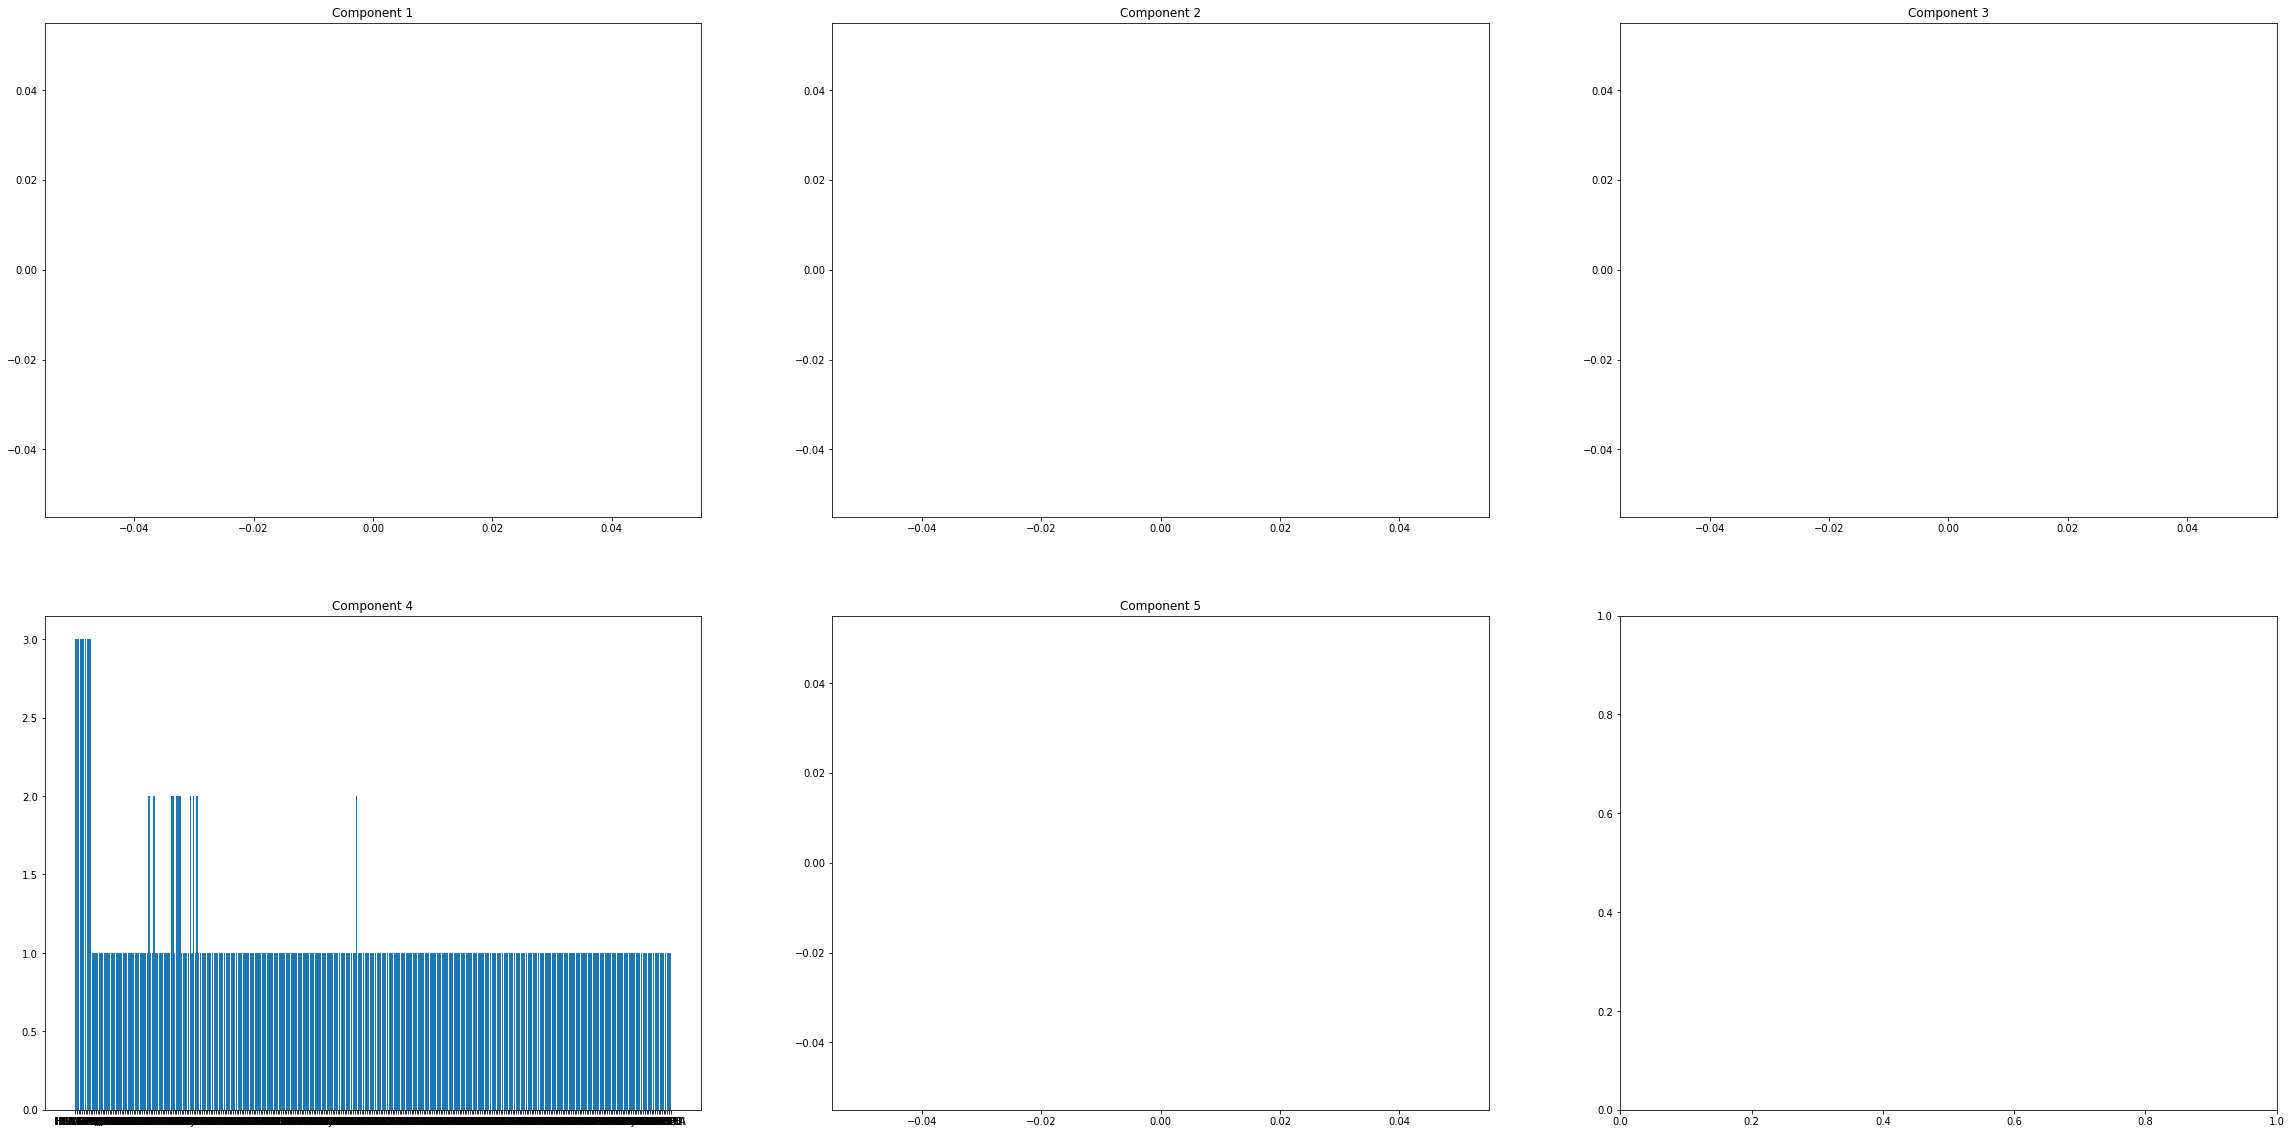

In [3]:
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 1
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

Text(0.5, 1.0, 'Component 5')

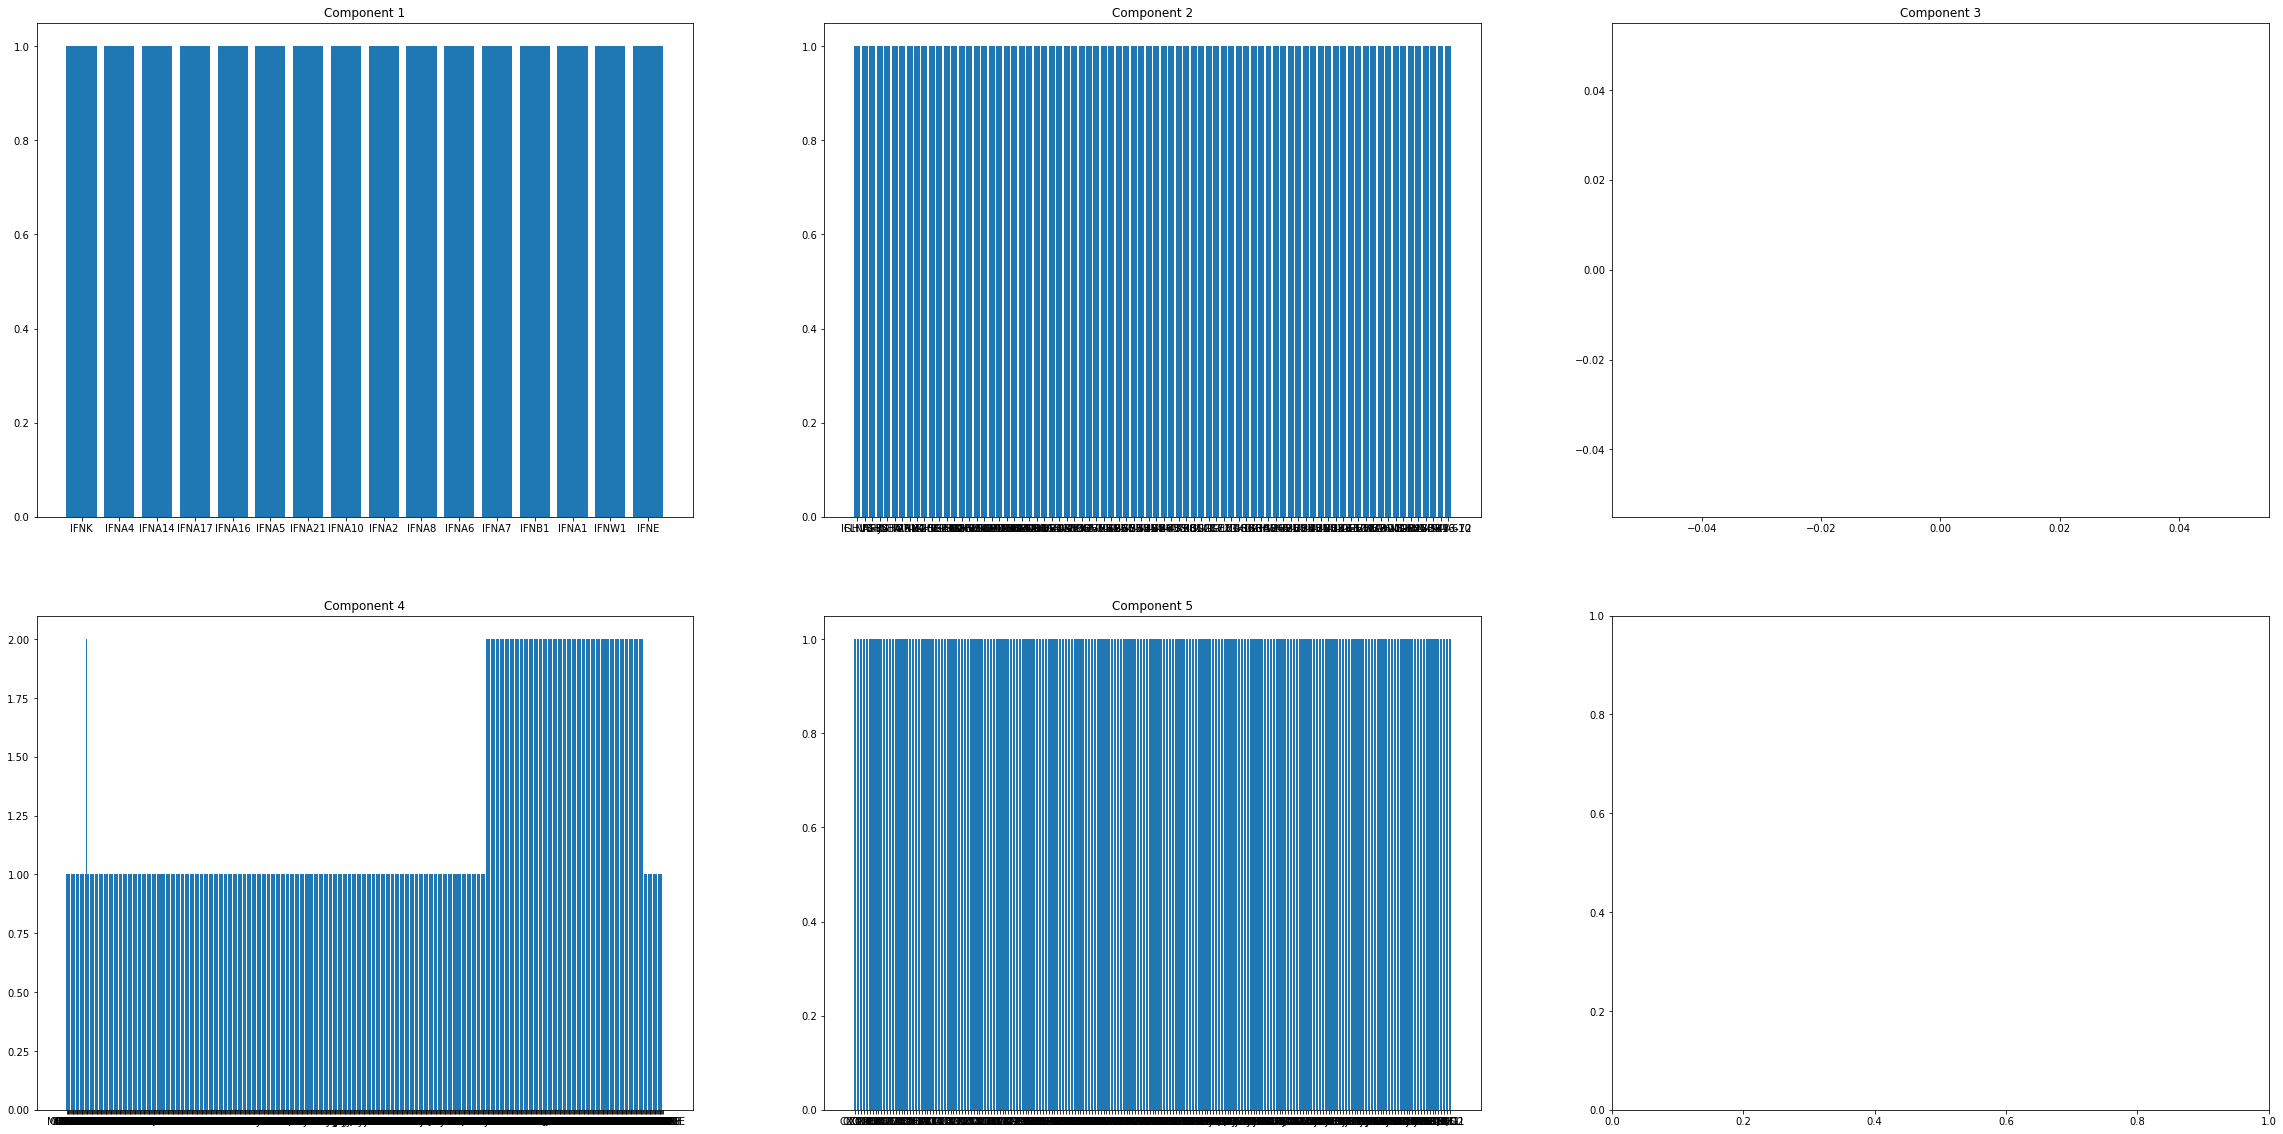

In [4]:
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 2
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

Text(0.5, 1.0, 'Component 5')

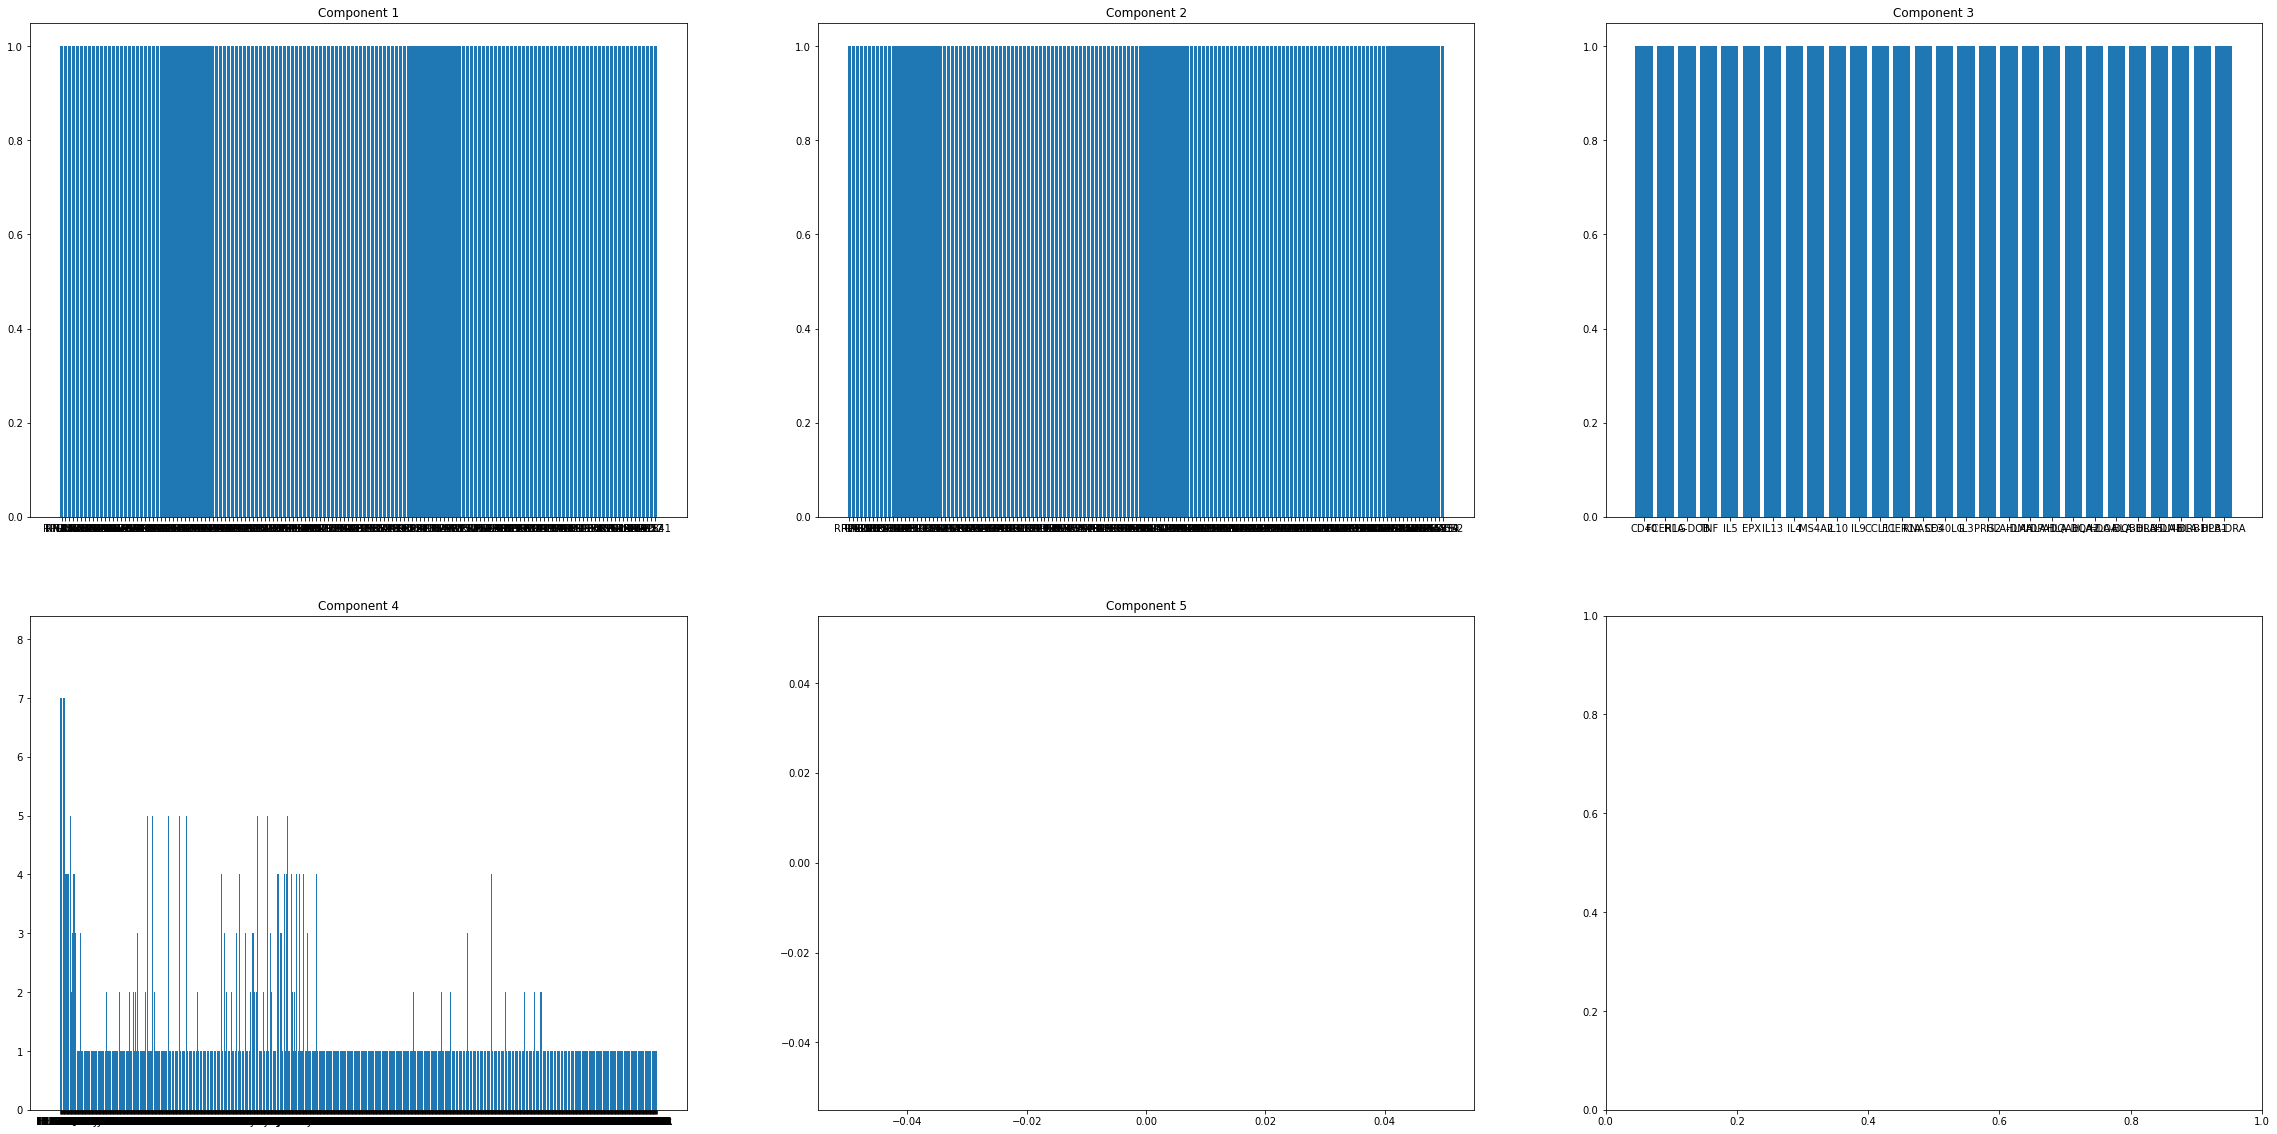

In [5]:
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 3
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

Text(0.5, 1.0, 'Component 5')

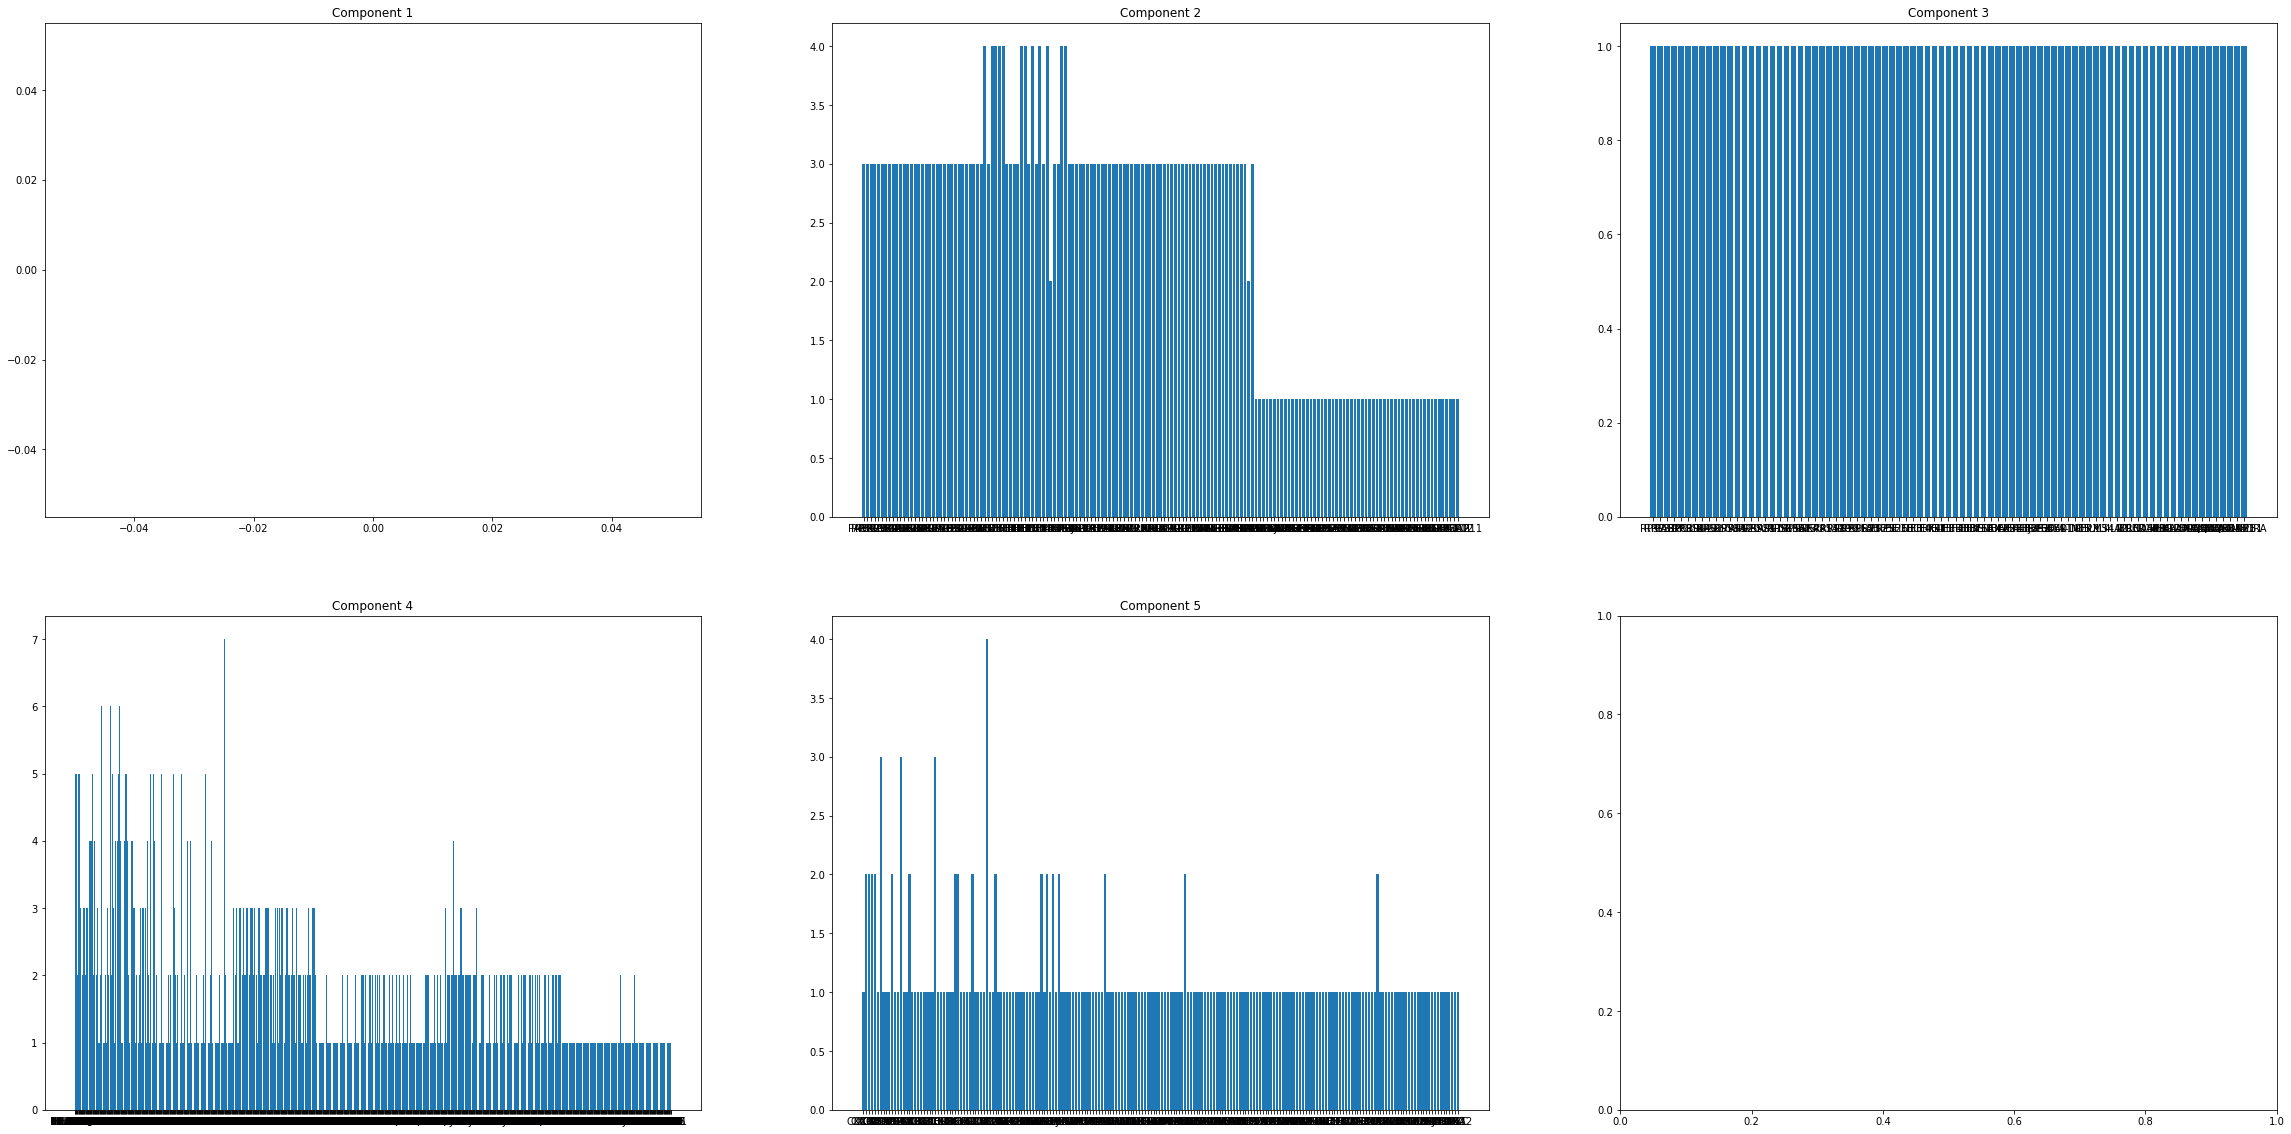

In [6]:
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 4
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

Text(0.5, 1.0, 'Component 5')

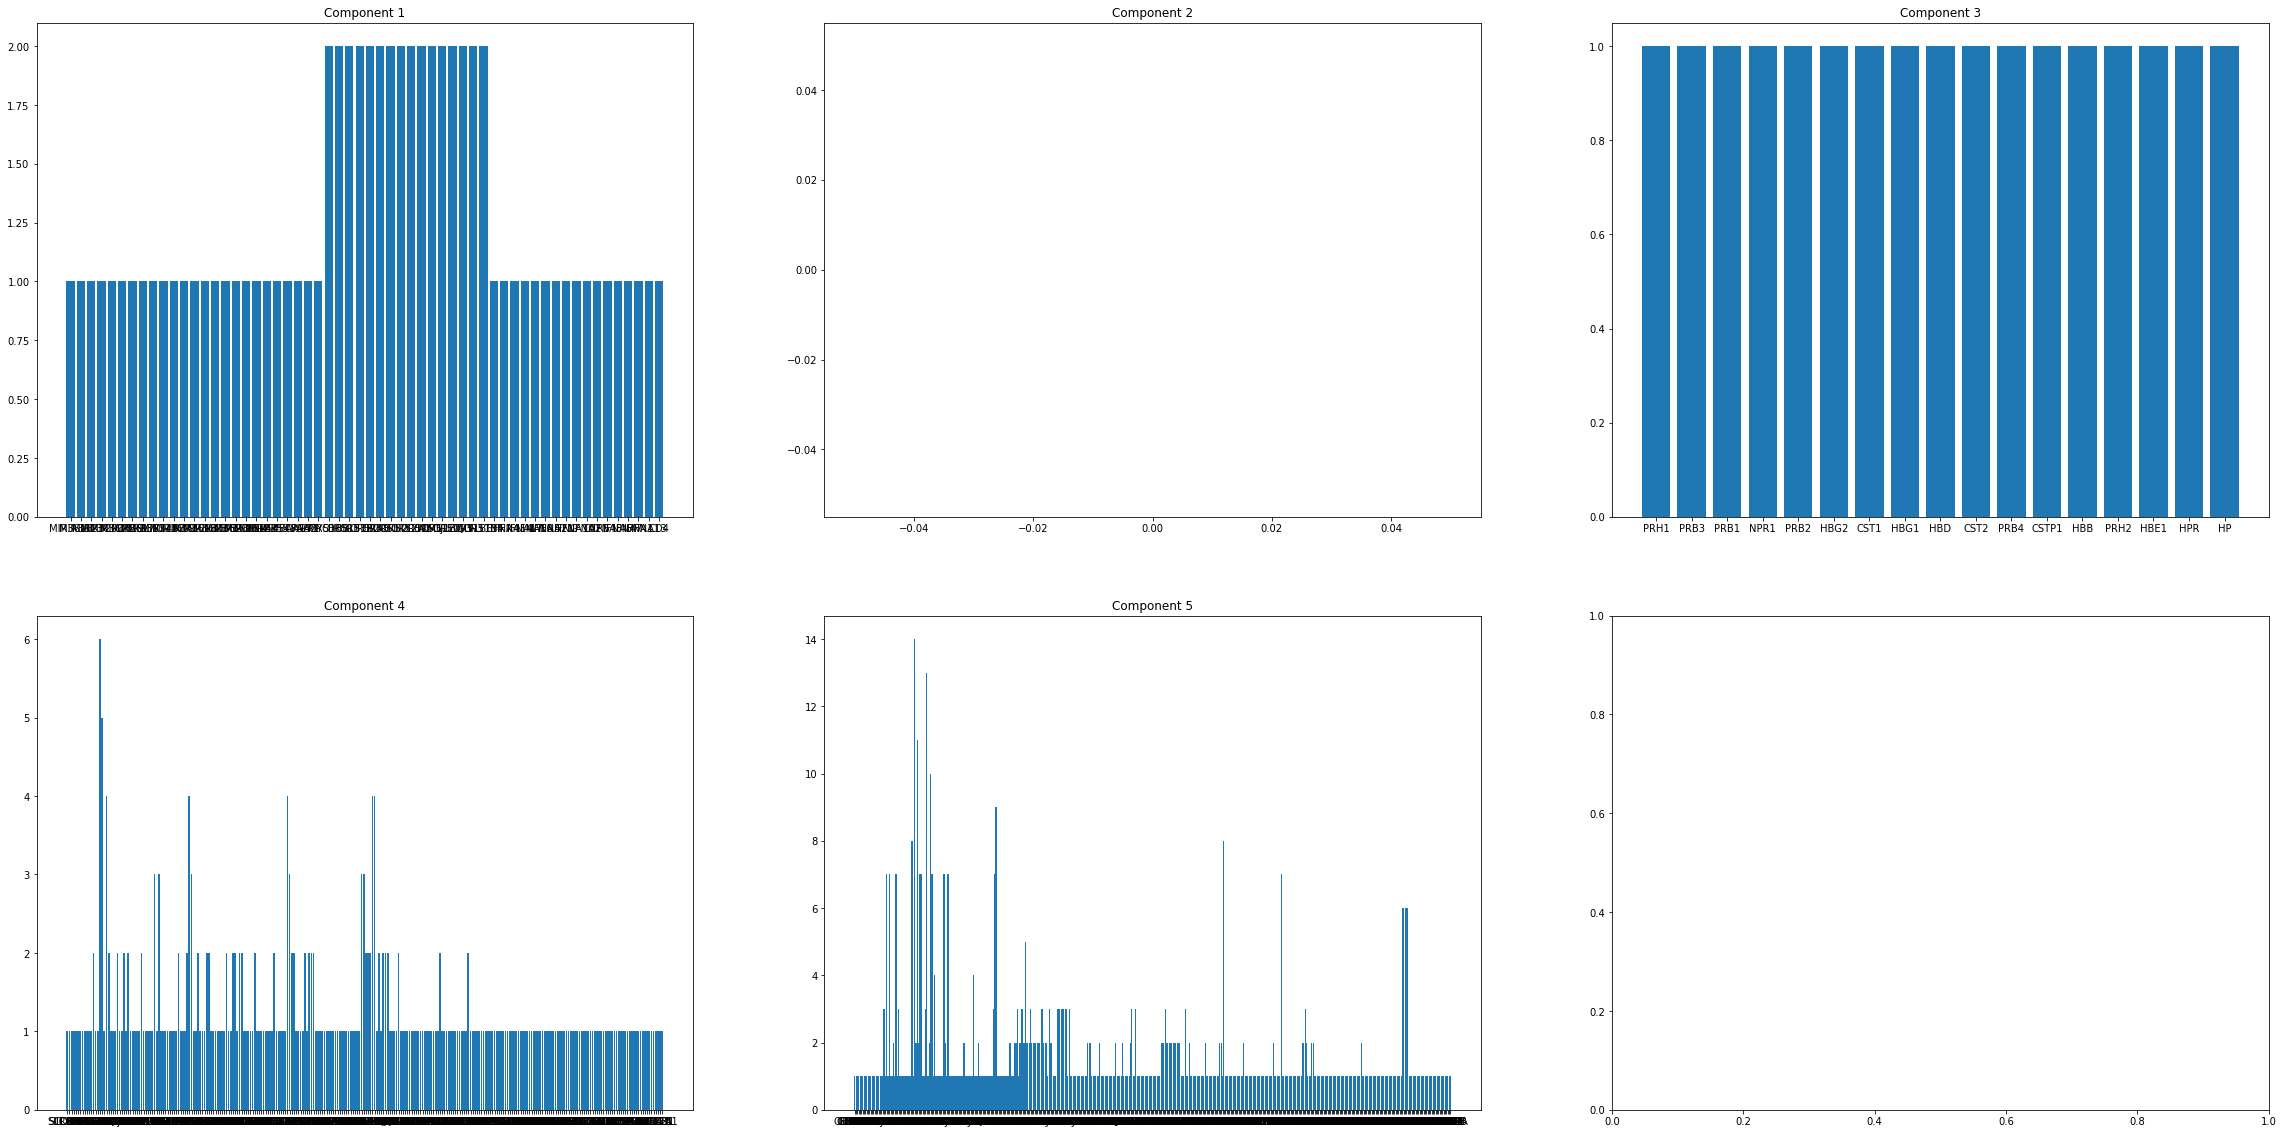

In [7]:
figs, axs = plt.subplots( 2,3, figsize=(40, 20))
gene_set = 5
axs[0,0].bar(filtered_dicts[gene_set][0].keys(),filtered_dicts[gene_set][0].values())
axs[0,0].set_title('Component 1')
axs[0,1].bar(filtered_dicts[gene_set][1].keys(),filtered_dicts[gene_set][1].values())
axs[0,1].set_title('Component 2')
axs[0,2].bar(filtered_dicts[gene_set][2].keys(),filtered_dicts[gene_set][2].values())
axs[0,2].set_title('Component 3')
axs[1,0].bar(filtered_dicts[gene_set][3].keys(),filtered_dicts[gene_set][3].values())
axs[1,0].set_title('Component 4')
axs[1,1].bar(filtered_dicts[gene_set][4].keys(),filtered_dicts[gene_set][4].values())
axs[1,1].set_title('Component 5')

In [3]:
#GIVES GENES THAT APPEAR MOST OFTENT
x = filtered_dicts[5][3]
{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}


In [5]:
filtered_gsets=[]
for each_set in filtered:
    my_dict = {}
    for a_component in each_set:
        for r in range(len(a_component)):
            g_set = a_component.reset_index()['Term'][r]
            if g_set in my_dict:
                my_dict[g_set] +=1
            else:
                my_dict[g_set] = 1
    filtered_gsets.append(my_dict)

In [6]:
#GIVES GENE SETS THAT APPEAR MOST OFTEN
x = filtered_gsets[5]
{k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}


In [42]:
###BELOW CODE PRINTS OUT MOST OR LEAST ENRICHED GENE SETS FOR A SPECIFIC COMPONENT

#all enriched gene sets for component 5
tot5 = pd.DataFrame()
for i in range(6):
    tot5 = pd.concat([tot5, filtered[i][4]])

#all enriched gene sets for component 4
tot4 = pd.DataFrame()
for i in range(6):
    tot4 = pd.concat([tot4, filtered[i][3]])

#all enriched gene sets
tot = pd.DataFrame()
for i in range(6):
    for j in range(5):
        tot = pd.concat([tot, filtered[i][j]])
just_score = ['es']
size_then_score = ['geneset_size', 'es']
matched_size_then_score = ['matched_size', 'es']

def enrichment_viewer( m_ascending, df, sort_by):
    """prints out list of gene sets in given dataframe sorted by either es or gene set size then es"""
    return df.sort_values(by = sort_by, ascending = m_ascending)

to_print = enrichment_viewer(m_ascending = True, df = tot5, sort_by = just_score)
to_print.head()

es  nes  pval  fdr  \
Term                                                                         
chemokine activity (GO:0008009)                   0.403301  inf   NaN  0.0   
U01AI038855                                       0.404293  inf   NaN  0.0   
K01DA015129                                       0.405219  inf   NaN  0.0   
P20RR016430                                       0.410636  inf   NaN  0.0   
Interleukin-1 regulation of extracellular matrix  0.418359  inf   NaN  0.0   

                                                  geneset_size  matched_size  \
Term                                                                           
chemokine activity (GO:0008009)                             47            45   
U01AI038855                                                 43            39   
K01DA015129                                                 24            22   
P20RR016430                                                 33            33   
Interleukin-1 regulation of extracellular matrix           120           119   

                                                                                              genes  \
Term                                                                                                  
chemokine activity (GO:0008009)                   CXCL3;CXCL2;CCL20;CXCL1;CCL2;PPBP;CXCL5;PF4;CC...   
U01AI038855                                       SOCS3;TPO;PTPRB;GPC6;NFE2L3;CCR2;CHST9;STXBP5L...   
K01DA015129                                       CHRNA9;CHRNE;GABBR2;CHRNA7;CHRNA2;CHRNG;CHRNA6...   
P20RR016430                                       SOCS3;GHRL;AGRP;HTR2C;NPY5R;POMC;GHSR;MC4R;CAR...   
Interleukin-1 regulation of extracellular matrix  SERPINB4;SERPINB3;C1R;CHI3L1;IL1R2;TNFAIP6;LCP...   

                                                                                        ledge_genes  
Term                                                                                                 
chemokine activity (GO:0008009)                                   CXCL3;CXCL2;CCL20;CXCL1;CCL2;PPBP  
U01AI038855                                                                         SOCS3;TPO;PTPRB  
K01DA015129                                                                            CHRNA9;CHRNE  
P20RR016430                                                                                   SOCS3  
Interleukin-1 regulation of extracellular matrix  SERPINB4;SERPINB3;C1R;CHI3L1;IL1R2;TNFAIP6;LCP...